#EECS 442 PS5: Scene Recognition

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Yuehan He, mperform
__Important__: after you download the .ipynb file, please name it as __\<your_uniqname\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

data_dir = "./data_miniplaces_modified"

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118
Using the GPU!


# Problem 5.1 Scene Recognition with VGG

You will build and train a convolutional neural network for scene recognition, i.e., classifying images into different scenes. You will need to:
1. Construct dataloaders for train/val/test datasets
2. Build MiniVGG and MiniVGG-BN (MiniVGG with batch-normalization layers)
3. Train MiniVGG and MiniVGG-BN, compare their training progresses and their final top-1 and top-5 accuracies.
4. (Optional) Increase the size of the network by adding more layers and check whether top-1 and top-5 accuracies will improve.

## Step 0: Downloading the dataset.



In [ ]:
# Download the miniplaces dataset
# Note: Restarting the runtime won't remove the downloaded dataset. You only need to re-download the zip file if you lose connection to colab.
!wget http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip

--2023-10-11 00:24:32--  http://www.eecs.umich.edu/courses/eecs504/data_miniplaces_modified.zip
Resolving www.eecs.umich.edu (www.eecs.umich.edu)... 141.212.113.116
Connecting to www.eecs.umich.edu (www.eecs.umich.edu)|141.212.113.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534628730 (510M) [application/zip]
Saving to: ‘data_miniplaces_modified.zip’

data_miniplaces_mod 100%[===================>] 509.86M  53.7MB/s    in 9.7s    

2023-10-11 00:24:42 (52.4 MB/s) - ‘data_miniplaces_modified.zip’ saved [534628730/534628730]



In [ ]:
# Unzip the download dataset .zip file to your local colab dir
# Warning: this upzipping process may take a while. Please be patient.
!unzip -q data_miniplaces_modified.zip

## 5.1 (a): Build dataloaders for train, val, and test

In [ ]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations.

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "val", "test" keys, each is mapped to a pytorch dataloader.
    """

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    ###########################################################################
    # TODO: Step 1: Build transformations for the dataset.                    #
    # You need to construct a data transformation that does three             #
    # preprocessing steps in order:                                           #
    # I. Resize the image to input_size using transforms.Resize               #
    # II. Convert the image to PyTorch tensor using transforms.ToTensor       #
    # III. Normalize the images with the provided mean and std parameters     #
    # using transforms.Normalize. These parameters are accumulated from a     #
    # large number of training samples.                                       #
    # You can use transforms.Compose to combine the above three               #
    # transformations. Store the combined transforms in the variable          #
    # 'composed_transform'.                                                   #
    ###########################################################################
    funcs = [transforms.Resize((input_size, input_size)), transforms.ToTensor(), transforms.Normalize(mean, std)] #group these into a triplet which is gonna be passed into the transforms.compose
    composed_transform = transforms.Compose(funcs)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    # We write the remaining part of the dataloader for you.
    # You are encouraged to go through this.

    ###########################################################################
    # Step 2: Build dataloaders.                                              #
    # I. We use torch.datasets.ImageFolder with the provided data_dir and the #
    # data transfomations you created in step 1 to construct pytorch datasets #
    # for training, validation, and testing.                                  #
    # II. Then we use torch.utils.data.DataLoader to build dataloaders with   #
    # the constructed pytorch datasets. You need to enable shuffling for      #
    # the training set. Set num_workers=2 to speed up dataloading.            #
    # III. Finally, we put the dataloaders into a dictionary.                 #
    ###########################################################################

    # Create train/val/test datasets
    data_transforms = {
        'train': composed_transform,
        'val': composed_transform,
        'test': composed_transform
    }
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=2) for x in data_transforms.keys()}

    return dataloaders_dict

In [ ]:
batch_size = 16
input_size = 128
dataloaders_dict = get_dataloaders(input_size, batch_size)

# Confirm your train/val/test sets contain 90,000/10,000/10,000 samples
print('# of training samples {}'.format(len(dataloaders_dict['train'].dataset)))
print('# of validation samples {}'.format(len(dataloaders_dict['val'].dataset)))
print('# of test samples {}'.format(len(dataloaders_dict['test'].dataset)))

# of training samples 90000
# of validation samples 10000
# of test samples 10000


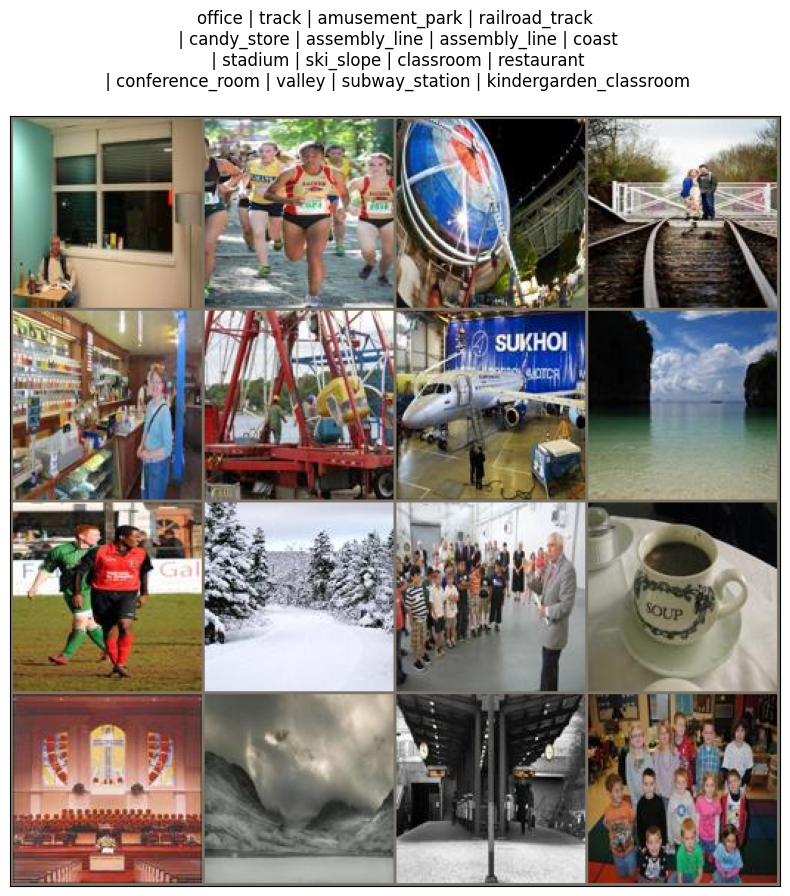

In [ ]:
# Visualize the data within the dataset
import json
with open('./data_miniplaces_modified/category_names.json', 'r') as f:
    class_names = json.load(f)['i2c']
class_names = {i:name for i, name in enumerate(class_names)}

def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

## 5.1 (b): Build MiniVGG and MiniVGG-BN

Please follow the instructions to build the two neural networks with architectures shown below.

__MiniVGG architecture__

![alt text](https://drive.google.com/uc?id=1RF3CjEsHBpRjubqwgBUxIEv54gpDjt95)

__MiniVGG-BN architecure__

![alt text](https://drive.google.com/uc?id=1HR5N2V-5RVT1u_bVzyCvhPJZ7PSnYm6x)


In [ ]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [ ]:
# Network configurations for all layers before the final fully-connected layers.
# "M" corresponds to maxpooling layer, integers correspond to number of output
# channels of a convolutional layer.
cfgs = {
    'MiniVGG': [64, 'M', 128, 'M', 128, 128, 'M'],
    'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']
}

def make_layers(cfg, batch_norm=False):
    """
    Return a nn.Sequential object containing all layers to get the features
    using the CNN. (That is, before the Average pooling layer in the two
    pictures above).

    Args:
      cfg: list
      batch_norm: bool, default: False. If set to True, a BatchNorm layer
                  should be added after each convolutional layer.

    Return:
      features: torch.nn.Sequential. Containers for all feature extraction
                layers. For use of torch.nn.Sequential, please refer to
                PyTorch documentation.
    """
    ###########################################################################
    # TODO: Construct the neural net architecture from cfg. You should use    #
    # nn.Sequential().                                                        #
    ###########################################################################
    layers = []
    channels = 3

    for item in cfg:
      #if it's M, it means we need to add a max-pooling layer to NN
      if item == 'M':
        layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
      else: # we want to add a convolutional layer with [item] output channels
        layer_2D = torch.nn.Conv2d(channels, item, kernel_size=3, padding=1)
        layers += [layer_2D]
        #if batch_norm is true, we want to add a batchnorm layer as well
        if batch_norm:
          layers += [torch.nn.BatchNorm2d(item)]
        layers += [torch.nn.ReLU(inplace=True)]#then we want to add the ReLU
        channels = item
    #unpack the layers we created, pass into sequential function
    features = torch.nn.Sequential(*layers)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return features

class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        #######################################################################
        # TODO: Construct the final FC layers using nn.Sequential.            #
        # Note: The average pooling layer has been defined by us above.       #
        #######################################################################
        #following the VGG screenshot from above
        #we have 4096 units for the first 2 layers
        self.classifier = torch.nn.Sequential(
                  torch.nn.Linear(3200, 512),
                  torch.nn.ReLU(True),
                  torch.nn.Dropout(p=0.3, inplace=False),
                  torch.nn.Linear(512,256),
                  torch.nn.ReLU(True),
                  torch.nn.Dropout(p=0.3, inplace=False),
                  torch.nn.Linear(256, num_classes)
        )




        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
vgg = VGG(features)

features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
vgg_bn = VGG(features)

# Print the network architectrue. Please compare the printed architecture with
# the one given in the instructions above.
# Make sure your network has the same architecture as the one we give above.
print(vgg)
print('Number of trainable parameters {}'.format(count_params(vgg)))

print(vgg_bn)
print('Number of trainable parameters {}'.format(count_params(vgg_bn)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=Tru

## 5.1 (c): Build training/validation loops

You will write a function for training and validating the network.

In [ ]:
def make_optimizer(model):
    """
    Args:
        model: NN to train

    Returns:
        optimizer: pytorch optmizer for updating the given model parameters.
    """
    ###########################################################################
    # TODO: Create a SGD optimizer with learning rate=1e-2 and momentum=0.9.  #
    # HINT: Check out optim.SGD() and initialize it with the appropriate      #
    # parameters. We have imported torch.optim as optim for you above.        #
    ###########################################################################
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return optimizer

def get_loss():
    """
    Returns:
        criterion: pytorch loss.
    """
    ###########################################################################
    # TODO: Create an instance of the cross entropy loss. This code           #
    # should be a one-liner.                                                  #
    ###########################################################################
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    return criterion

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                ###############################################################
                # TODO:                                                       #
                # Please read all the inputs carefully!                       #
                # For "train" phase:                                          #
                # (i)   Compute the outputs using the model                   #
                #       Also, use the  outputs to calculate the class         #
                #       predicted by the model,                               #
                #       Store the predicted class in 'preds'                  #
                #       (Think: argmax of outputs across a dimension)         #
                #       torch.max() might help!                               #
                # (ii)  Use criterion to store the loss in 'loss'             #
                # (iii) Update the model parameters                           #
                # Notes:                                                      #
                # - Don't forget to zero the gradients before beginning the   #
                # loop!                                                       #
                # - "val" phase is the same as train, but without backprop    #
                # - Compute the outputs (Same as "train", calculate 'preds'   #
                # too),                                                       #
                # - Calculate the loss and store it in 'loss'                 #
                ###############################################################
                # Zeroing the parameter gradients
                optimizer.zero_grad()
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):  # Only compute gradients in train phase
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                ###############################################################
                #                         END OF YOUR CODE                    #
                ###############################################################

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained
                # weights.
                # You should download the trained weights to your local machine.
                # Later, you can load these weights directly without needing to
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)

    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

## 5.1 (d): Train MiniVGG / MiniVGG-BN

In [ ]:
# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training
batch_size = 128

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

### IO
# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# get dataloaders and criterion function
input_size = 64
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

In [ ]:
# Initialize MiniVGG
features = make_layers(cfgs['MiniVGG'], batch_norm=False)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg, tr_his, val_his = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG')

Epoch 0/19
----------


100%|██████████| 704/704 [01:37<00:00,  7.25it/s]


train Loss: 4.4901 Acc: 0.0220


100%|██████████| 79/79 [00:09<00:00,  8.63it/s]


val Loss: 4.2339 Acc: 0.0434
Epoch 1/19
----------


100%|██████████| 704/704 [01:29<00:00,  7.88it/s]


train Loss: 4.0836 Acc: 0.0648


100%|██████████| 79/79 [00:07<00:00, 11.03it/s]


val Loss: 3.8424 Acc: 0.1046
Epoch 2/19
----------


100%|██████████| 704/704 [01:25<00:00,  8.24it/s]


train Loss: 3.7678 Acc: 0.1121


100%|██████████| 79/79 [00:08<00:00,  9.37it/s]


val Loss: 3.5968 Acc: 0.1396
Epoch 3/19
----------


100%|██████████| 704/704 [01:28<00:00,  7.93it/s]


train Loss: 3.5435 Acc: 0.1474


100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


val Loss: 3.4586 Acc: 0.1600
Epoch 4/19
----------


100%|██████████| 704/704 [01:26<00:00,  8.18it/s]


train Loss: 3.3539 Acc: 0.1797


100%|██████████| 79/79 [00:09<00:00,  8.21it/s]


val Loss: 3.2248 Acc: 0.2064
Epoch 5/19
----------


100%|██████████| 704/704 [01:24<00:00,  8.37it/s]


train Loss: 3.2051 Acc: 0.2087


100%|██████████| 79/79 [00:09<00:00,  8.68it/s]


val Loss: 3.1354 Acc: 0.2188
Epoch 6/19
----------


100%|██████████| 704/704 [01:25<00:00,  8.19it/s]


train Loss: 3.0795 Acc: 0.2301


100%|██████████| 79/79 [00:08<00:00,  9.31it/s]


val Loss: 2.9932 Acc: 0.2523
Epoch 7/19
----------


100%|██████████| 704/704 [01:23<00:00,  8.44it/s]


train Loss: 2.9658 Acc: 0.2518


100%|██████████| 79/79 [00:08<00:00,  9.27it/s]


val Loss: 2.9374 Acc: 0.2649
Epoch 8/19
----------


100%|██████████| 704/704 [01:29<00:00,  7.88it/s]


train Loss: 2.8694 Acc: 0.2716


100%|██████████| 79/79 [00:11<00:00,  7.07it/s]


val Loss: 2.8180 Acc: 0.2832
Epoch 9/19
----------


100%|██████████| 704/704 [01:24<00:00,  8.32it/s]


train Loss: 2.7677 Acc: 0.2921


100%|██████████| 79/79 [00:10<00:00,  7.83it/s]


val Loss: 2.7885 Acc: 0.2922
Epoch 10/19
----------


100%|██████████| 704/704 [01:28<00:00,  7.97it/s]


train Loss: 2.6713 Acc: 0.3140


100%|██████████| 79/79 [00:11<00:00,  6.75it/s]


val Loss: 2.7896 Acc: 0.2942
Epoch 11/19
----------


100%|██████████| 704/704 [01:25<00:00,  8.26it/s]


train Loss: 2.5785 Acc: 0.3314


100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


val Loss: 2.7777 Acc: 0.2937
Epoch 12/19
----------


100%|██████████| 704/704 [01:28<00:00,  7.98it/s]


train Loss: 2.4977 Acc: 0.3471


100%|██████████| 79/79 [00:08<00:00,  8.91it/s]


val Loss: 2.7593 Acc: 0.3009
Epoch 13/19
----------


100%|██████████| 704/704 [01:27<00:00,  8.01it/s]


train Loss: 2.4121 Acc: 0.3660


100%|██████████| 79/79 [00:09<00:00,  8.68it/s]


val Loss: 2.6726 Acc: 0.3197
Epoch 14/19
----------


100%|██████████| 704/704 [01:26<00:00,  8.14it/s]


train Loss: 2.3185 Acc: 0.3843


100%|██████████| 79/79 [00:08<00:00,  9.48it/s]


val Loss: 2.6895 Acc: 0.3239
Epoch 15/19
----------


100%|██████████| 704/704 [01:24<00:00,  8.34it/s]


train Loss: 2.2466 Acc: 0.3993


100%|██████████| 79/79 [00:07<00:00, 11.22it/s]


val Loss: 2.7252 Acc: 0.3205
Epoch 16/19
----------


100%|██████████| 704/704 [01:15<00:00,  9.33it/s]


train Loss: 2.1657 Acc: 0.4154


100%|██████████| 79/79 [00:07<00:00, 11.26it/s]


val Loss: 2.6988 Acc: 0.3236
Epoch 17/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.54it/s]


train Loss: 2.0765 Acc: 0.4333


100%|██████████| 79/79 [00:07<00:00, 10.70it/s]


val Loss: 2.7364 Acc: 0.3275
Epoch 18/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.51it/s]


train Loss: 1.9987 Acc: 0.4528


100%|██████████| 79/79 [00:08<00:00,  9.73it/s]


val Loss: 2.7532 Acc: 0.3283
Epoch 19/19
----------


100%|██████████| 704/704 [01:12<00:00,  9.70it/s]


train Loss: 1.9218 Acc: 0.4674


100%|██████████| 79/79 [00:08<00:00,  9.29it/s]

val Loss: 2.7992 Acc: 0.3180
Best val Acc: 0.328300


In [ ]:
# Initialize MiniVGG-BN
features = make_layers(cfgs['MiniVGG-BN'], batch_norm=True)
model = VGG(features).to(device)
optimizer = make_optimizer(model)

# Train the model!
vgg_BN, tr_his_BN, val_his_BN = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='MiniVGG-BN')

Epoch 0/19
----------


100%|██████████| 704/704 [01:15<00:00,  9.31it/s]


train Loss: 4.2058 Acc: 0.0477


100%|██████████| 79/79 [00:08<00:00,  9.44it/s]


val Loss: 3.8485 Acc: 0.0894
Epoch 1/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.50it/s]


train Loss: 3.6263 Acc: 0.1263


100%|██████████| 79/79 [00:08<00:00,  9.23it/s]


val Loss: 3.4484 Acc: 0.1557
Epoch 2/19
----------


100%|██████████| 704/704 [01:16<00:00,  9.16it/s]


train Loss: 3.3524 Acc: 0.1752


100%|██████████| 79/79 [00:06<00:00, 11.32it/s]


val Loss: 3.4143 Acc: 0.1746
Epoch 3/19
----------


100%|██████████| 704/704 [01:15<00:00,  9.31it/s]


train Loss: 3.1861 Acc: 0.2053


100%|██████████| 79/79 [00:06<00:00, 11.44it/s]


val Loss: 3.0771 Acc: 0.2289
Epoch 4/19
----------


100%|██████████| 704/704 [01:16<00:00,  9.22it/s]


train Loss: 3.0520 Acc: 0.2313


100%|██████████| 79/79 [00:07<00:00, 11.28it/s]


val Loss: 2.9784 Acc: 0.2413
Epoch 5/19
----------


100%|██████████| 704/704 [01:15<00:00,  9.34it/s]


train Loss: 2.9549 Acc: 0.2500


100%|██████████| 79/79 [00:07<00:00, 11.18it/s]


val Loss: 2.8693 Acc: 0.2681
Epoch 6/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.51it/s]


train Loss: 2.8619 Acc: 0.2719


100%|██████████| 79/79 [00:07<00:00, 10.94it/s]


val Loss: 2.8895 Acc: 0.2706
Epoch 7/19
----------


100%|██████████| 704/704 [01:16<00:00,  9.23it/s]


train Loss: 2.7790 Acc: 0.2878


100%|██████████| 79/79 [00:07<00:00, 11.04it/s]


val Loss: 2.7617 Acc: 0.2955
Epoch 8/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.48it/s]


train Loss: 2.7049 Acc: 0.3035


100%|██████████| 79/79 [00:07<00:00, 10.31it/s]


val Loss: 2.7037 Acc: 0.3055
Epoch 9/19
----------


100%|██████████| 704/704 [01:16<00:00,  9.18it/s]


train Loss: 2.6349 Acc: 0.3181


100%|██████████| 79/79 [00:06<00:00, 11.47it/s]


val Loss: 2.7124 Acc: 0.3049
Epoch 10/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.50it/s]


train Loss: 2.5647 Acc: 0.3309


100%|██████████| 79/79 [00:06<00:00, 11.38it/s]


val Loss: 2.6768 Acc: 0.3125
Epoch 11/19
----------


100%|██████████| 704/704 [01:16<00:00,  9.23it/s]


train Loss: 2.5046 Acc: 0.3452


100%|██████████| 79/79 [00:08<00:00,  9.58it/s]


val Loss: 2.6660 Acc: 0.3194
Epoch 12/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.50it/s]


train Loss: 2.4428 Acc: 0.3561


100%|██████████| 79/79 [00:08<00:00,  9.40it/s]


val Loss: 2.5840 Acc: 0.3368
Epoch 13/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.58it/s]


train Loss: 2.3825 Acc: 0.3707


100%|██████████| 79/79 [00:08<00:00,  9.48it/s]


val Loss: 2.5770 Acc: 0.3343
Epoch 14/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.50it/s]


train Loss: 2.3236 Acc: 0.3832


100%|██████████| 79/79 [00:08<00:00,  9.35it/s]


val Loss: 2.6021 Acc: 0.3324
Epoch 15/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.61it/s]


train Loss: 2.2646 Acc: 0.3931


100%|██████████| 79/79 [00:08<00:00,  9.28it/s]


val Loss: 2.5439 Acc: 0.3408
Epoch 16/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.46it/s]


train Loss: 2.2122 Acc: 0.4050


100%|██████████| 79/79 [00:08<00:00,  9.52it/s]


val Loss: 2.5675 Acc: 0.3415
Epoch 17/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.64it/s]


train Loss: 2.1462 Acc: 0.4208


100%|██████████| 79/79 [00:08<00:00,  9.51it/s]


val Loss: 2.5006 Acc: 0.3547
Epoch 18/19
----------


100%|██████████| 704/704 [01:13<00:00,  9.63it/s]


train Loss: 2.0917 Acc: 0.4314


100%|██████████| 79/79 [00:08<00:00,  9.33it/s]


val Loss: 2.4938 Acc: 0.3595
Epoch 19/19
----------


100%|██████████| 704/704 [01:14<00:00,  9.39it/s]


train Loss: 2.0410 Acc: 0.4445


100%|██████████| 79/79 [00:07<00:00,  9.95it/s]

val Loss: 2.5441 Acc: 0.3486
Best val Acc: 0.359500


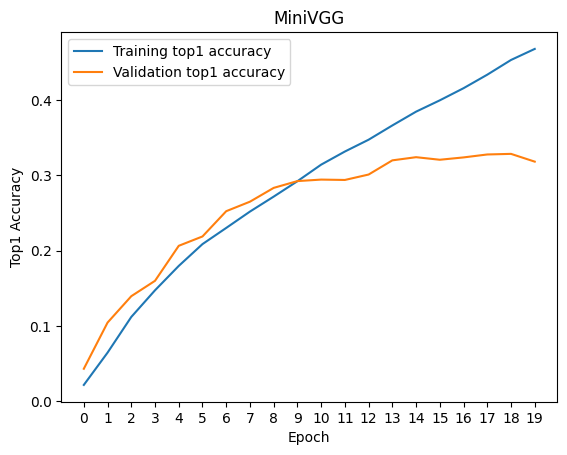

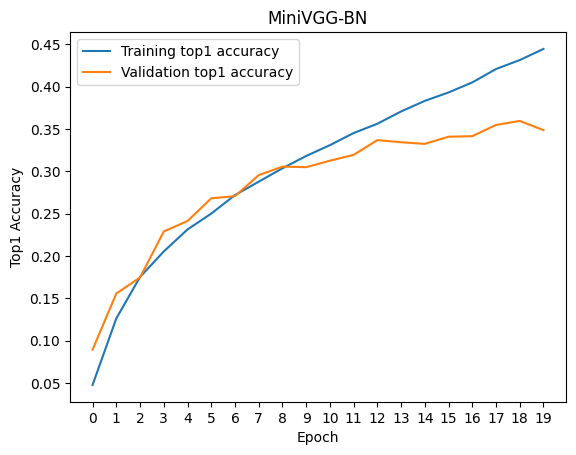

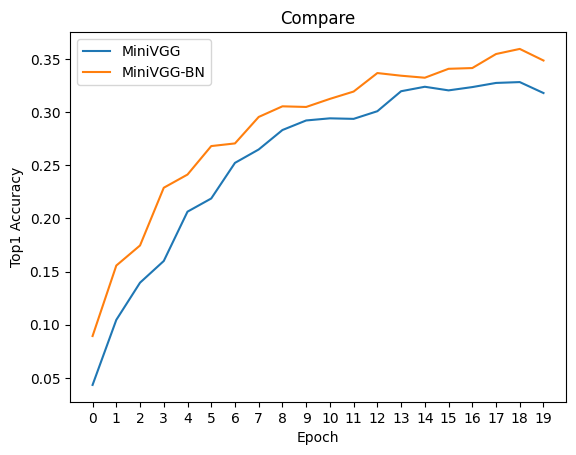

In [ ]:
x = np.arange(num_epochs)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, torch.tensor(tr_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG')
plt.show()

# train/val accuracies for MiniVGG-BN
plt.plot(x, torch.tensor(tr_his_BN, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('MiniVGG-BN')
plt.show()

# compare val accuracies of MiniVGG and MiniVGG-BN
plt.plot(x, torch.tensor(val_his, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_BN, device = 'cpu'))
plt.legend(['MiniVGG', 'MiniVGG-BN'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('Compare')
plt.show()

### TODO: __Summarize the effect of batch normalization:__






In [ ]:
#Batch normalization allows the VGG training to be come more accurate as we increase the Epoch.

Batch normalization allows the VGG training to be come more accurate as we increase the Epoch.

In [ ]:
pickle.dump(tr_his, open('tr_his.pkl', 'wb'))
pickle.dump(tr_his_BN, open('tr_his_BN.pkl', 'wb'))
pickle.dump(val_his, open('val_his.pkl', 'wb'))
pickle.dump(val_his_BN, open('val_his_BN.pkl', 'wb'))

## Step 6. Measure top1 and top5 accuracies of MiniVGG and MiniVGG-BN

__Definition of top-k accuracy__: if the correct label is within the _top k_ predicted classes according to the network output scores, we count the prediction by the neural network as a correct prediction.

In [ ]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values
    of k.

    Args:
        output: pytorch tensor, (batch_size x num_classes). Outputs of the
                network for one batch.
        target: pytorch tensor, (batch_size,). True labels for one batch.

    Returns:
        res: list. Accuracies corresponding to topk[0], topk[1], ...
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def test(model, dataloader):

    model.eval()

    top1_acc = []
    top5_acc = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            res = accuracy(outputs, labels, topk=(1, 5))

            top1_acc.append(res[0] * len(outputs))
            top5_acc.append(res[1] * len(outputs))

    print('Top-1 accuracy {}%, Top-5 accuracy {}%'.format(sum(top1_acc).item()/10000, sum(top5_acc).item()/10000))

In [ ]:
##### To pass the test, both networks should have Top-5 accuracy above 55% #####
vgg_BN.load_state_dict(torch.load('./weights/MiniVGG-BN.pth'))
vgg.load_state_dict(torch.load('./weights/MiniVGG.pth'))

test(vgg_BN, dataloaders['test'])
test(vgg, dataloaders['test'])

Top-1 accuracy 36.56%, Top-5 accuracy 65.9%
Top-1 accuracy 32.83%, Top-5 accuracy 62.17%


## 5.2 (a-b): Build small ResNet model (Optional)

Please follow this figure to build the Residual Block and the Resnet model. We already implemented the back bone of the resnet model. You have to code the ResNet Block and the classifier part which are shown in the figure.

__ResNet architecture__

![alt text](https://drive.google.com/uc?id=1YFECibK--zL2jrG9Bodgj_38EA_2J79_)



In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        ###########################################################################
        # TODO: Code the residual block as depicted in the above figure. You should use    #
        # nn.Sequential().                                                        #
        ###########################################################################




        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################

    def forward(self, x):

        ###########################################################################
        # TODO: Code the forward pass for the residual block as depicted in the above figure.
        # Note: The relu activation function is after the skip connection.                                                        #
        ###########################################################################




        #######################################################################
        #                              END OF YOUR CODE                       #
        #######################################################################
        return out

In [ ]:

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()

        ###########################################################################
        # Construct the neural net architecture for the resnet model. You should use nn.Sequential().
        # Note: We already implemented most of the network you just need to code the initial layers and insert the residual blocks.
        ###########################################################################

        self.backbone = nn.Sequential(
                        ###########################################################################
                        # TODO: Code the initial layers i.e the the strided convolution layer, batchnorm, relu, maxpool layer and the residual blocks
                        #Hint: you have to make use of the "block" variable.
                        ###########################################################################



                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                        nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(128),
                        nn.ReLU()),
                        ###########################################################################
                        # TODO: Insert the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################


                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                        nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(256),
                        nn.ReLU()),
                        ###########################################################################
                        # TODO: Insert the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################


                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################
                        nn.Sequential(
                        nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU()),
                        ###########################################################################
                        # TODO: Insert the residual block please follow the figure for the number of channels and the flow of layers.
                        ###########################################################################



                        #######################################################################
                        #                              END OF YOUR CODE                       #
                        #######################################################################


        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:

resnet = ResNet(ResidualBlock, [1, 1, 1, 1], 100)
print(resnet)
print('Number of trainable parameters {}'.format(count_params(resnet)))


## 5.2 (c): Train ResNet (Optional)

In [ ]:

# Initialize ResNet
resnet = ResNet(ResidualBlock, [1, 1, 1, 1], num_classes).to(device)
optimizer = make_optimizer(resnet)

# Train the model!
resnet, tr_his_res, val_his_res = train_model(model=resnet, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, num_epochs=num_epochs, model_name='ResNet')



In [ ]:

# train/val accuracies for ResNet
plt.figure()
plt.plot(x, torch.tensor(tr_his_res, device = 'cpu'))
plt.plot(x, torch.tensor(val_his_res, device = 'cpu'))
plt.legend(['Training top1 accuracy', 'Validation top1 accuracy'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Top1 Accuracy')
plt.title('ResNet')
plt.show()

In [ ]:
pickle.dump(tr_his_res, open('tr_his_res.pkl', 'wb'))
pickle.dump(val_his_res, open('val_his_res.pkl', 'wb'))

In [ ]:
##### (Optional) Network should have Top-5 accuracy above 55% #####
resnet.load_state_dict(torch.load('./weights/ResNet.pth'))
test(resnet, dataloaders['test'])

# Convert Notebook to PDF


In [ ]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '' # Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS 442 Fall 2023 - PS1.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')